# (Global) Reshuffling CIFAR 10

Training a transformer layer to unscramble images.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
from fastai.vision import *
import torch

In [52]:
class GlobalShuffle:
    def __init__(self, numRows, numCols):
        self.numRows = numRows
        self.numCols = numCols
        self.permuteVector = np.random.permutation(numRows * numCols)
        self.unpermuteVector = np.empty(numRows * numCols, self.permuteVector.dtype)
        self.unpermuteVector[self.permuteVector] = np.arange(numRows * numCols)
        
    def permuteArr(self, imgArr):
        """Permutes RGB rank 3 image"""
        flatImgArr = np.reshape(imgArr, (self.numRows * self.numCols, -1))
        flatPermutedArr = flatImgArr[self.permuteVector]
        return flatPermutedArr.reshape((self.numRows, self.numCols, -1))
    
    def unPermuteArr(self, imgArr):
        """Permutes RGB rank 3 image"""
        flatImgArr = np.reshape(imgArr, (self.numRows * self.numCols, -1))
        flatPermutedArr = flatImgArr[self.unpermuteVector]
        return flatPermutedArr.reshape((self.numRows, self.numCols, -1))

In [15]:
shuffle = GlobalShuffle(3, 3)
sampleArr = np.arange(9).reshape((3, 3, 1))
print(sampleArr.squeeze())
print(shuffle.permuteArr(sampleArr).squeeze())

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[8 4 0]
 [5 1 6]
 [2 3 7]]


## Loading CIFAR 10 dataset

In [89]:
! ls cifar10/train

airplane   bird       deer       frog       ship
automobile cat        dog        horse      truck


In [90]:
data = ImageDataBunch.from_folder('cifar10/', size=32)

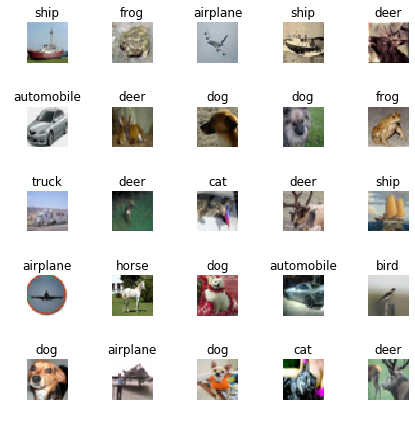

In [91]:
data.show_batch(row=3, figsize=(6,6))

### Shuffle on the CIFAR 10 Dataset

In [93]:
cifarShuffle = GlobalShuffle(32, 32)

(32, 32, 3)


Text(0.5, 1.0, 'Unshuffled: cat')

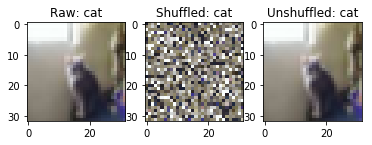

In [94]:
img, label = train_dataset[0]
np_img = img.data.numpy().transpose((1, 2, 0))
print(np_img.shape)
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(np_img)
ax[0].set_title(f"Raw: {label}")

shuffled_img = cifarShuffle.permuteArr(np_img)
ax[1].imshow(shuffled_img)
ax[1].set_title(f"Shuffled: {label}")

unshuffled_img = cifarShuffle.unPermuteArr(shuffled_img)
ax[2].imshow(unshuffled_img)
ax[2].set_title(f"Unshuffled: {label}")

### 0. (Control) Learning on Shuffled CIFAR 10

Can we learn anything on this dataset?

In [95]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (torch.FloatTensor([ 0.4914 ,  0.48216,  0.44653]), torch.FloatTensor([ 0.24703,  0.24349,  0.26159]))
data = ImageDataBunch.from_folder('cifar10/', size=32).normalize(stats)

#### Basic resnet-18 performance on Unshuffled

In [100]:
cnn_learner = create_cnn(data, models.resnet18, metrics=[accuracy])

/Users/ngundotra/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [101]:
cnn_learner.lr_find()

epoch     train_loss  valid_loss  accuracy  time    
0         14.655864   #na#        00:30     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/Users/ngundotra/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


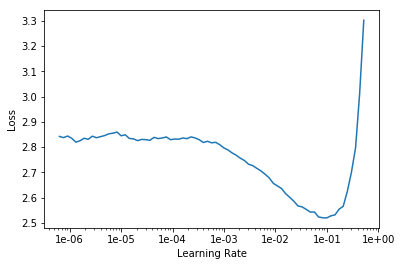

In [102]:
cnn_learner.recorder.plot()

In [103]:
cnn_learner.fit_one_cycle(1)

epoch     train_loss  valid_loss  accuracy  time    
0         1.462065    1.344793    0.524300  04:36     


In [105]:
cnn_learner.fit(2, lr=1e-1)

epoch     train_loss  valid_loss  accuracy  time    
0         2.468005    3.159616    0.272800  04:45     
1         2.126750    6.297695    0.403400  04:31     


In [ ]:
cnn_learner.fit_one_cycle

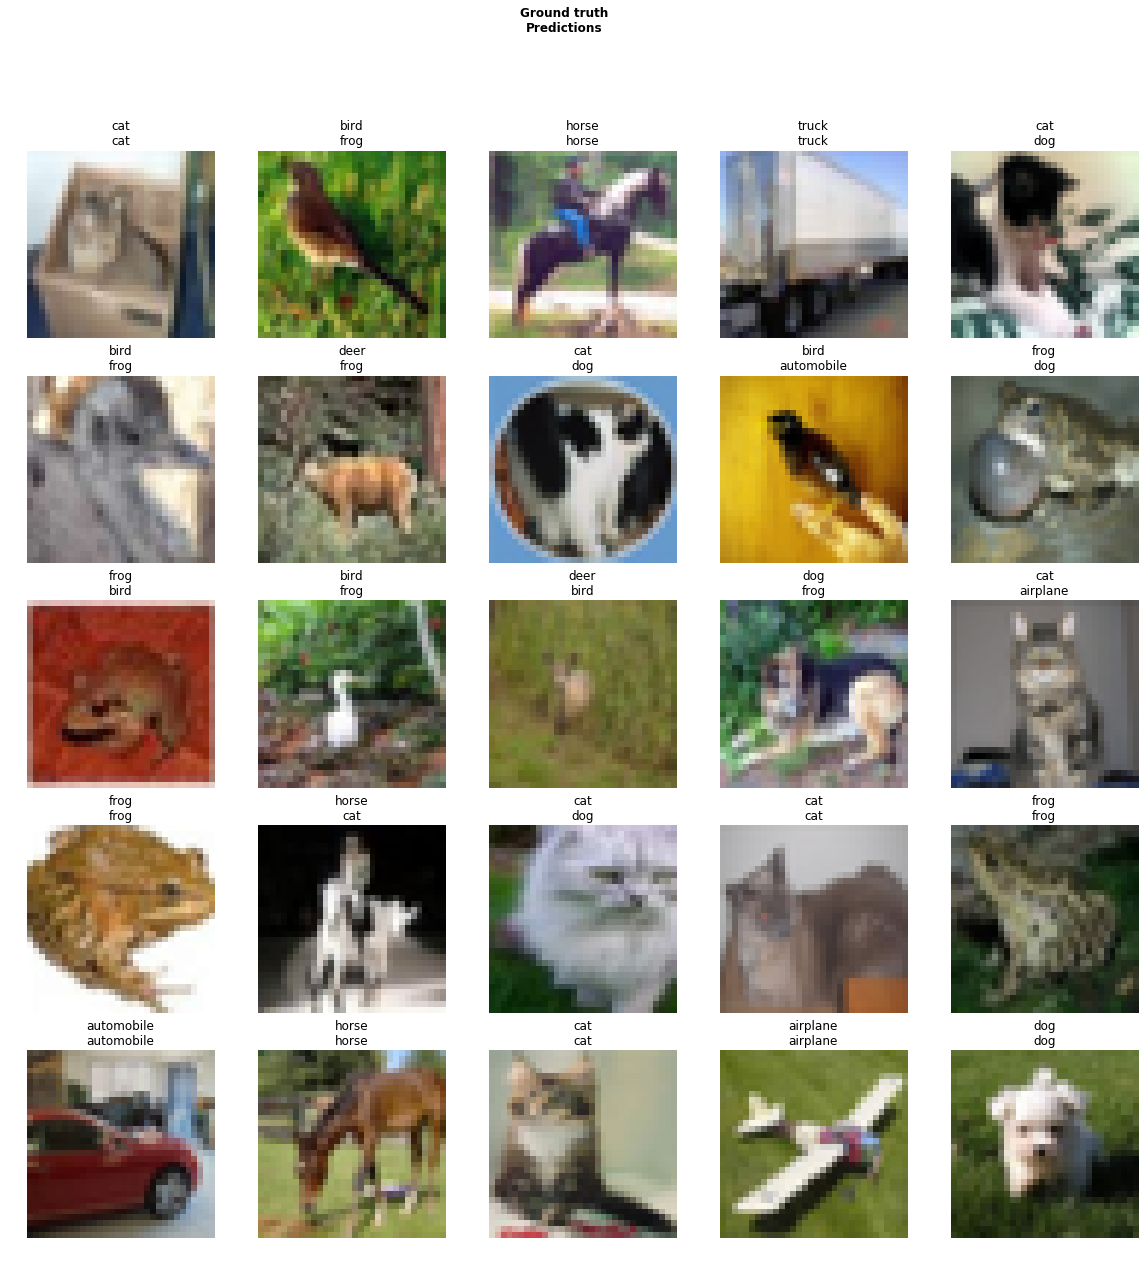

In [98]:
cnn_learner.show_results(DatasetType.Train)